In [1]:
import cv2
import numpy as np
from enum import Enum

WEIGHTS = 'weights/2019-10-07_16-17-19_epoch 06_r2 0.8368.h5'

DEVICE = 0
WIDTH = 224
HEIGHT = 224

class State(Enum):
    SEARCH = 1
    TRACK = 2

"""
User Interface Stuff (You can ignore this)
"""
import IPython
import ipywidgets as widgets
from IPython.display import display

ipython = IPython.get_ipython()

style = {'description_width': 'initial'}

w_image = widgets.Image(width=WIDTH, height=HEIGHT, format='png',
                        layout=widgets.Layout(width='100%'))
w_thresh = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.01, 
                                             description='Minimum Tracking Confidence',
                                             layout=widgets.Layout(width='100%'),
                                             style=style)

vbox = widgets.VBox([w_image, w_thresh])

display(vbox)

In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
from keras.applications.mobilenet import preprocess_input

config = tf.ConfigProto()
config.gpu_options.allow_growth = True 
sess = tf.Session(config=config)
set_session(sess) 

from model import build_model

model, _, _ = build_model(weights=None, cls=True, regr=True)
model.load_weights(WEIGHTS, by_name=True)

Using TensorFlow backend.
W1007 11:21:06.965774 139740303312704 deprecation_wrapper.py:119] From /home/carroll/anaconda3/envs/ryzen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1007 11:21:06.970491 139740303312704 deprecation_wrapper.py:119] From /home/carroll/anaconda3/envs/ryzen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1007 11:21:06.980454 139740303312704 deprecation_wrapper.py:119] From /home/carroll/anaconda3/envs/ryzen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1007 11:21:06.980814 139740303312704 deprecation_wrapper.py:119] From /home/carroll/anaconda3/envs/ryzen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name t

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_left (InputLayer)         (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_right (InputLayer)        (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_left[0][0]                 
                                                                 input_right[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 8)  216         conv1_pad[0][0]                  
          

In [ ]:
cap = cv2.VideoCapture(4)

state = State.SEARCH
objects = []
img_initial = None
last_pos = None

try:
    while True:
        # Have to call this to get update values from sliders / dropdowns
        ipython.kernel.do_one_iteration()
        
        # Read the frame from the camera
        ret, frame = cap.read()
        
        if frame.shape[0] < frame.shape[1]:
            frame = cv2.copyMakeBorder(frame, 0, frame.shape[1] - frame.shape[0], 0, 0, cv2.BORDER_CONSTANT, 0)
        elif frame.shape[0] > frame.shape[1]:
            frame = cv2.copyMakeBorder(frame, 0, 0, 0, frame.shape[0] - frame.shape[1], cv2.BORDER_CONSTANT, 0)
            
        frame_search = frame

        img_draw = frame_search.copy()
        
        if state == State.SEARCH:
                    
            # Resize the frame to a lower resolution for performance reasons
            img_original = cv2.resize(frame, (WIDTH, HEIGHT))
            search_ratio = WIDTH/frame.shape[0]

            # Convert image to greyscale
            img_grey = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
            
            # Apply a slight guassian blur (low pass filter) to filter out noise
            img_blur = cv2.GaussianBlur(img_grey, (3, 3), 0)
    
            img_final = img_blur
            
            # Only compute the difference image if we have both a current and previous frame
            if img_initial is not None:
                
                # By looking at the difference between our two images, we can find motion
                img_diff = cv2.absdiff(img_initial, img_final)
    
                # Quantizes pixels to only represent ON or OFF instead of a wide range of intensity values
                _, img_threshold = cv2.threshold(img_diff, 32, 255, cv2.THRESH_BINARY)
    
                # Each ON pixel expands in every direction.
                img_dilate = cv2.dilate(img_threshold, None, iterations=8)
                
                # A contour is a group of "on" pixels that are connected to eachother
                # Here we represent contours by the lines that form their edges
                cnts = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)[0]
    
                
                # Iterate through every contour we found and determine if it should get a bounding box
                for c in cnts:
                    # If the contour is too small, ignore it
                    if cv2.contourArea(c) < int(0.026 * WIDTH * HEIGHT):
                        continue
    
                    # Convert the contour to a rectangle starting at (x, y) with a width w and height h
                    (x, y, w, h) = cv2.boundingRect(c)
                                
                    x, y, w, h = np.array([x, y, w, h])/search_ratio
                    x, y, w, h = int(x), int(y), int(w), int(h)
                    
                    cv2.rectangle(img_draw, (x, y), (x + w, y + h), (0, 0, 0), 2)
                    
                    objects.append([x, y, x+w, y+h])
                    
                    state = State.TRACK
                    img_initial = None
                
            # Visualization Code
            result, img_png = cv2.imencode('.png', img_draw)
            w_image.value = img_png.tobytes()

            img_initial = img_final
            
        elif state == State.TRACK:                        
            prune = []
                        
            for idx, obj in enumerate(objects):
                
                x1, y1, x2, y2 = obj
                
                siamese_images = np.zeros((2, 224, 224, 3), dtype=np.float32)

                width = x2 - x1
                height = y2 - y1

                center = np.round((np.array([x1, y1]) + np.array([x2, y2])) / 2)
                size = 2*max(width, height)

                size_half = np.ceil(size / 2)

                sx1 = center[0] - size_half
                sy1 = center[1] - size_half

                sx2 = center[0] + size_half
                sy2 = center[1] + size_half

                # Caclulate padding
                s_pad_left = int(abs(sx1)) if sx1 < 0 else 0
                s_pad_right = int(sx2 - frame.shape[1]) if sx2 > frame.shape[1] else 0

                s_pad_top = int(abs(sy1)) if sy1 < 0 else 0
                s_pad_bot = int(sy2 - frame.shape[0]) if sy2 > frame.shape[0] else 0

                pad_bot = s_pad_bot + 100
                pad_top = s_pad_top + 100

                pad_left = s_pad_left + 100
                pad_right = s_pad_right + 100

                # Recalculate crop regions after padding
                x1 += pad_left
                x2 += pad_left

                y1 += pad_top
                y2 += pad_top

                center = np.round((np.array([x1, y1]) + np.array([x2, y2])) / 2)

                sx1 = center[0] - size_half
                sy1 = center[1] - size_half

                sx2 = center[0] + size_half
                sy2 = center[1] + size_half

                # Pad the actual images
                image_padded_track = cv2.copyMakeBorder(frame_track,
                                                  pad_top, pad_bot, pad_left, pad_right,
                                                  cv2.BORDER_CONSTANT, value=0)
                image_cropped_track = image_padded_track[int(sy1):int(sy2), int(sx1):int(sx2)]
                image_resized_track = cv2.resize(image_cropped_track, (224, 224), interpolation=cv2.INTER_LINEAR)
                siamese_images[0] = image_resized_track

                image_padded_search = cv2.copyMakeBorder(frame_search,
                                                  pad_top, pad_bot, pad_left, pad_right,
                                                  cv2.BORDER_CONSTANT, value=0)
                image_cropped_search = image_padded_search[int(sy1):int(sy2), int(sx1):int(sx2)]
                image_resized_search = cv2.resize(image_cropped_search, (224, 224), interpolation=cv2.INTER_LINEAR)
                siamese_images[1] = image_resized_search
                
                track_ratio = 224/(sy2 - sy1)

                # Jointly Normalize both images
                siamese_images = preprocess_input(siamese_images)

                regr, cls = model.predict([[siamese_images[0]], [siamese_images[1]]])
                
                regr = regr[0]
                cls = cls[0]
                
                x1, y1, x2, y2 = regr
                
                regr = regr/track_ratio
                regr += [sx1-pad_left, sy1-pad_top, sx1-pad_left, sy1-pad_top]
                
                x1, y1, x2, y2 = regr
                                
                objects[idx] = np.round(
                    (np.array(regr) + np.array(objects[idx]))/2).astype(np.int).tolist()
                
                if cls < w_thresh.value:
                    prune.append(idx)
                    cv2.rectangle(img_draw, (int(x1), int(y1)), (int(x2), int(y2)) , (0, 0, 255), 2)
                else:
                    pass
                    cv2.rectangle(img_draw, (int(x1), int(y1)), (int(x2), int(y2)) , (0, 255, 0), 2)

                result, img_png = cv2.imencode('.png', img_draw)
                w_image.value = img_png.tobytes()
                    
            prune.reverse()
            for p in prune:
                del objects[p]
                
            if len(objects) == 0:
                state = State.SEARCH



        frame_track = frame.copy()

        
except KeyboardInterrupt:
    pass
finally:
    cap.release()


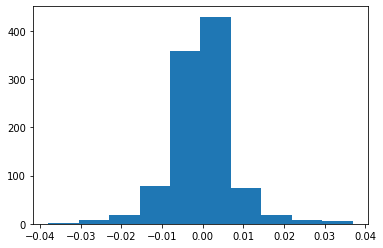

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.random.laplace(0, 0.005, (1000,))
plt.hist(x)
plt.show()

In [4]:
np.ceil(-0.5)

-0.0